# Deep Learning Baseline For U-NET model

## 1. Introduction
Deep neural networks are used mainly for supervised learning: classification or regression and segmentation. Thus, we want to build a baseline deep learning model for our project which is the Truck Segmentation. 
- This baseline includes all the steps of a deep learning project
<img src="model.png" style="width: 800px;">

## 2. Dataset 

### Supervised Segmentation Problem Dataset
There are two parts of a supervised segmentation problem dataset.

- Original Image 
- Mask Images 
<img src="ship_img_cut.png" style="width: 800px;">

### Introduction to the reference dataset
To test the baseline and the implementation of U-Net model, we have borrowed the dataset from https://www.kaggle.com/c/tgs-salt-identification-challenge
- Several areas of Earth with large accumulations of oil and gas also have huge deposits of salt below the surface.<br>
- But unfortunately, knowing where large salt deposits are precisely is very difficult. Professional seismic imaging still requires expert human interpretation of salt bodies. This leads to very subjective, highly variable renderings. 
- More alarmingly, it leads to potentially dangerous situations for oil and gas company drillers.
- To create the most accurate seismic images and 3D renderings, TGS (the world’s leading geoscience data company) is hoping Kaggle’s machine learning community will be able to build an algorithm that automatically and accurately identifies if a subsurface target is salt or not.

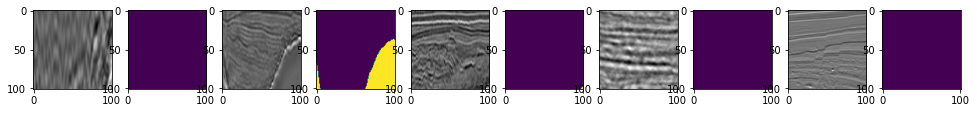

In [5]:
ids= ['5b7c160d0d']
show_sample(ids,train_path_images,train_path_masks)

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from glob import glob
import sys
import random
from tqdm import tqdm_notebook
from skimage.io import imread, imshow
from skimage.transform import resize
from sklearn.metrics import jaccard_score
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dsets
from torch.autograd import Variable
from dataset import TruckDataset
from utils import list_ids,train_ds,shuffle,normalize_reshape,show_sample
import matplotlib.pyplot as plt
from model import Unet

In [3]:
# Set some parameters
im_width = 128
im_height = 128
im_chan = 1
path_train = 'test_dataset/train'
path_test = 'test_dataset/test'

train_path_images = os.path.abspath(path_train + "/images/")
train_path_masks = os.path.abspath(path_train + "/masks/")

test_path_images = os.path.abspath(path_test + "/images/")
test_path_masks = os.path.abspath(path_test + "/masks/")


In [4]:
train_path_images_list = glob(os.path.join(train_path_images, "*.png"))
train_path_masks_list = glob(os.path.join(train_path_masks, "*.png"))
test_path_images_list = glob(os.path.join(test_path_images, "*.png"))
test_path_masks_list = glob(os.path.join(test_path_masks, "*.png"))

In [6]:
train_ids = list_ids(train_path_images)
X_train, Y_train = train_ds(path_train,train_ids,im_height = 128,im_width = 128,im_chan=1)

Getting and resizing train images and masks ... 



Done!


In [7]:
X_train_shaped, Y_train_shaped = normalize_reshape(X_train, Y_train)
train_idxs, val_idxs = shuffle(X_train_shaped, val_size = 0.1)
truck_ID_dataset_train = TruckDataset(X_train_shaped[train_idxs], 
                                      train=True, 
                                      preprocessed_masks=Y_train_shaped[train_idxs])
truck_ID_dataset_val = TruckDataset(X_train_shaped[val_idxs], 
                                      train=True, 
                                      preprocessed_masks=Y_train_shaped[val_idxs])

batch_size = 16

train_loader = torch.utils.data.DataLoader(dataset=truck_ID_dataset_train, 
                                           batch_size=batch_size, 
                                           shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset=truck_ID_dataset_val, 
                                           batch_size=batch_size, 
                                           shuffle=False)

## 3. Defining The Model
### 3.1. Choosing the model - U-Net Model
After researching some deep learning models for Segmentation Problem, we find that U-Net is a good model to use and easy to implement. Also, from U-Net, we can optimize and generate better Deep Learning model later such as Residual U-Net! 
<img src="u-net.png" style="width: 800px;">

In [8]:
model = Unet()
model

Unet(
  (double_conv1): double_conv(
    (conv): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (double_conv2): double_conv(
    (conv): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=

### 3.2 Defining the Loss Function and Optimizer, Metric
#### Loss Function - Binary Cross Entropy 
- Because are training a binary segmentation problem, we want to use binary cross-entropy / log loss as our loss function.
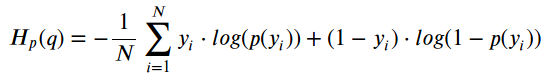

#### Optimizer - Adam
Also, we choose Adam as our optimizer due to its efficiency 

#### Metric - Intersection-Over-Union (IOU)
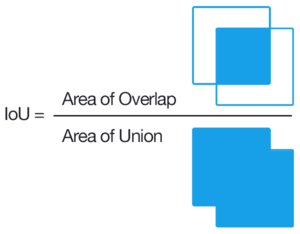

### 3.3 Training The Model

Now that we have defined the data loaders, model, loss function and optimizer, we are ready to train the model. Here's what it looks like in pseudocode:

```
for epoch in range(num_epochs):
    # Training phase
    for batch in train_loader:
        # Generate predictions
        # Calculate loss
        # Compute gradients
        # Update weights
        # Reset gradients
    
    # Validation phase
    for batch in val_loader:
        # Generate predictions
        # Calculate loss
        # Calculate metrics (accuracy etc.)
    # Calculate average validation loss & metrics
    
    # Log epoch, loss & metrics for inspection
```

In [17]:
model = Unet()
criterion = nn.BCEWithLogitsLoss()

learning_rate = 1e-3
epoches = 10
threshold = 0.5
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
mean_train_losses = []
mean_val_losses = []
mean_accuracies = []
for epoch in range(epoches):
    train_losses = []
    val_losses = []
    accuracies = []
    ious = []
    for images, masks in train_loader:        
        images = Variable(images)
        masks = Variable(masks)
        
        outputs = model(images)  
        output_acc = torch.sigmoid(outputs)
        output_acc = output_acc.cpu().data.numpy()
        output_acc = (output_acc > threshold).astype(int)
        iou = jaccard_score(masks.flatten(), output_acc.flatten())
        ious.append(iou)
        loss = criterion(outputs, masks)
        train_losses.append(loss.data)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    for images, masks in val_loader:
        images = Variable(images)
        masks = Variable(masks)
        
        outputs = model(images)
        loss = criterion(outputs, masks)
        val_losses.append(loss.data)
    
    mean_train_losses.append(np.mean(train_losses))
    accuracies = [np.mean(ious > iou_threshold)
                     for iou_threshold in np.linspace(0.5,0.95,10)]
    mean_accuracies.append(np.mean(accuracies))
    mean_val_losses.append(np.mean(val_losses))
    # Print Loss
    print('Epoch: {}. Train Loss: {}. Val Loss: {}. IOU Metric: {}'.format(epoch+1, np.mean(train_losses), np.mean(val_losses),np.mean(accuracies)))

Epoch: 1. Train Loss: 0.42149490118026733. Val Loss: 0.3232356905937195. IOU Metric: 0.14044444444444443
Epoch: 2. Train Loss: 0.336916446685791. Val Loss: 0.27521735429763794. IOU Metric: 0.196
Epoch: 3. Train Loss: 0.29527661204338074. Val Loss: 0.27273863554000854. IOU Metric: 0.296
Epoch: 4. Train Loss: 0.28543511033058167. Val Loss: 0.24082475900650024. IOU Metric: 0.32133333333333336
Epoch: 5. Train Loss: 0.26506495475769043. Val Loss: 0.24268202483654022. IOU Metric: 0.35733333333333334
Epoch: 6. Train Loss: 0.2587977349758148. Val Loss: 0.21085752546787262. IOU Metric: 0.376
Epoch: 7. Train Loss: 0.23913130164146423. Val Loss: 0.1954648196697235. IOU Metric: 0.4057777777777778
Epoch: 8. Train Loss: 0.2265634685754776. Val Loss: 0.2062550187110901. IOU Metric: 0.43466666666666665
Epoch: 9. Train Loss: 0.21506622433662415. Val Loss: 0.18887867033481598. IOU Metric: 0.47733333333333333
Epoch: 10. Train Loss: 0.21418610215187073. Val Loss: 0.18254095315933228. IOU Metric: 0.4537777

Text(0.5, 1.0, 'Relationship between training loss and validation loss')

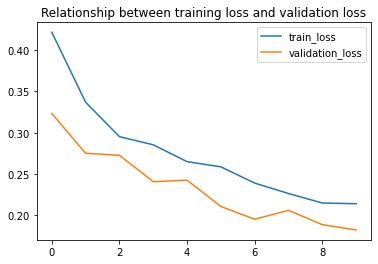

In [25]:
train_loss_series = pd.Series(mean_train_losses)
train_accuracy_series = pd.Series(mean_accuracies)
val_loss_series = pd.Series(mean_val_losses)
train_loss_series.plot(label="train_loss")
val_loss_series.plot(label="validation_loss")
plt.legend()
plt.title("Relationship between training loss and validation loss")

Text(0.5, 1.0, 'Training Accuracy')

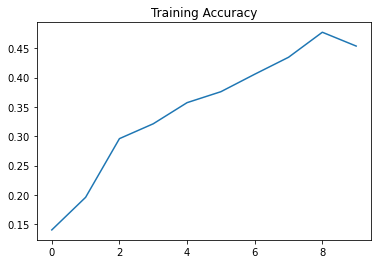

In [27]:
train_accuracy_series.plot(label="train_accuracy")
plt.title("Training Accuracy")

## 4. Evaluate The Model

In [30]:
y_pred_true_pairs = []
for images, masks in val_loader:
    images = Variable(images)
    y_preds = model(images)
    for i, _ in enumerate(images):
        y_pred = y_preds[i] 
        y_pred = torch.sigmoid(y_pred)
        y_pred = y_pred.cpu().data.numpy()
        y_pred_true_pairs.append((y_pred, masks[i].numpy()))


In [34]:
y_pred = y_preds[0] 
y_pred = torch.sigmoid(y_pred)
y_pred = y_pred.cpu().data.numpy()

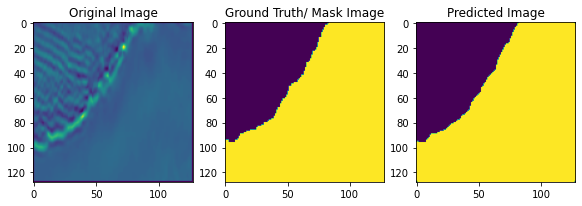

In [65]:
plt.figure(figsize=(20,10))
plt.subplot(1,2*(1+2),2*2-1)
plt.imshow(np.reshape(images[0],(128,128)))
plt.title("Original Image")
plt.subplot(1,2*(1+2),2*2)
plt.title("Ground Truth/ Mask Image")
plt.imshow(np.reshape(masks[0],(128,128)))
plt.subplot(1,2*(1+2),2*2+1)
plt.title("Predicted Image")
plt.imshow(res)
plt.show()